In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive



## **Import Libraries**

In [0]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.patches as mpatches
import time

# Classifier Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import RobustScaler
from xgboost import XGBClassifier
import xgboost

import collections

# Other Libraries
from sklearn.model_selection import train_test_split
from imblearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, fbeta_score, roc_auc_score, accuracy_score, classification_report, auc
from sklearn.metrics import make_scorer
from sklearn.metrics import average_precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import StratifiedShuffleSplit

 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from itertools import chain




## Pre-define Functions

In [0]:
# 다양한 방법으로 아웃라이어 제거를 하려고 rm_outliers_neg_1(df,*args), rm_outliers_pos_1(df,*args)를 만들었는데,
# 최종적으로 선택한 아웃라이어 제거 방법 하에서 둘이 동일한 함수가 되었음을 참고하시길. 
 
def rm_outliers_neg_1(df,*args):                                                # *args에 'V10', 'V12', 'V14', 'V16' 넣을 것임을 염두해 두기
                                                                                # 참고로 어떤 feature에서 아웃라이어를 제거할지는 샘플링 후 corr matrix 찍어봐야 알 수 있는 사실.
    # Negative correlation outliers delete in Class 1 up & down
    # in our case, remove the columns, V10, V12, V14, V16.                      
    outliers_neg = []
    outliers_neg_idx = []
    for i, v in enumerate(args):
        
        fraud = df[v].loc[df['Class'] == 1].values                              # Return a Numpy representation of the DataFrame
        q25, q75 = np.percentile(fraud, 25), np.percentile(fraud, 75)
        iqr = q75 - q25

        cut_off = iqr * 1.5
        lower, upper = q25 - cut_off, q75 + cut_off
        outlier = [x for x in fraud if (x > upper or x < lower)]
        if outlier != []:
            outliers_neg.append(outlier)
            outliers_neg_idx.append(df[df[v].isin(outlier)].index.values)       # df[v].isin(outlier)은 True/False로 이루어짐.
        
    return np.unique(list(chain(*outliers_neg_idx)))                            # chain(*iterable)은 iterable한 객체들을 인수로 받아 하나의 iterator로 반환
                                                                                # ndarray를 리턴


        
def rm_outliers_pos_1(df,*args):                                                # *args에 'V4', 'V11' 넣을 것임을 염두해 두기
                                                                                # 참고로 어떤 feature에서 아웃라이어를 제거할지는 샘플링 후 corr matrix 찍어봐야 알 수 있는 사실.
    
    # positive correlation outliers delete in Class 1 up & down
    # in our case, remove the columns, V4, V11.                                 
    outliers_pos = []
    outliers_pos_idx = []
    for i, v in enumerate(args):
        
        fraud = df[v].loc[df['Class'] == 1].values
        q25, q75 = np.percentile(fraud, 25), np.percentile(fraud, 75)
        iqr = q75 - q25

        cut_off = iqr * 1.5
        lower, upper = q25 - cut_off, q75 + cut_off
        outlier = [x for x in fraud if (x > upper or x < lower)]
        if outlier != []:
            outliers_pos.append(outlier)
            outliers_pos_idx.append(df[df[v].isin(outlier)].index.values)

    return np.unique(list(chain(*outliers_pos_idx)))                            # ndarray를 리턴

In [0]:
def print_metrics(original_ytest, prediction):

    print('---' * 45)
    print("accuracy: {:.4f}".format(accuracy_score(original_ytest, prediction)))
    print("precision: {:.4f}".format(precision_score(original_ytest, prediction)))
    print("recall: {:.4f}".format(recall_score(original_ytest, prediction)))
    print("f1: {:.4f}".format(f1_score(original_ytest, prediction)))
    print("f2: {:.4f}".format(fbeta_score(original_ytest, prediction, beta=2)))
    print("ROC_auc: {:.4f}".format(roc_auc_score(original_ytest, prediction)))
    print("rmse: {:.4f}".format(np.sqrt(mean_squared_error(original_ytest, prediction))))
    print('---' * 45)


In [0]:
# Confusion Matrix
def plot_confusion_matrix(original_ytest, nbc_pred, log_reg_pred, knn_pred, svc_pred, dtc_pred, rfc_pred, votc_pred, bagc_pred, xgbc_pred):

  nbc_cm = confusion_matrix(original_ytest, nbc_pred)
  log_reg_cm = confusion_matrix(original_ytest, log_reg_pred)
  knn_cm = confusion_matrix(original_ytest, knn_pred)
  svc_cm = confusion_matrix(original_ytest, svc_pred)
  dtc_cm = confusion_matrix(original_ytest, dtc_pred)
  rfc_cm = confusion_matrix(original_ytest, rfc_pred)
  votc_cm = confusion_matrix(original_ytest, votc_pred)
  bagc_cm = confusion_matrix(original_ytest, bagc_pred)
  xgbc_cm = confusion_matrix(original_ytest, xgbc_pred)

  fig, ax = plt.subplots(3,3,figsize=(22,12))

  sns.heatmap(nbc_cm, ax=ax[0][0], annot=True, fmt='d', cmap=plt.cm.copper)
  ax[0][0].set_title("Naive Bayses \n Confusion Matrix", fontsize=14)
  ax[0][0].set_xticklabels(['', ''], fontsize=14, rotation=90)
  ax[0][0].set_yticklabels(['', ''], fontsize=14, rotation=360)

  sns.heatmap(log_reg_cm, ax=ax[0][1], annot=True, fmt='d', cmap=plt.cm.copper)
  ax[0][1].set_title("Logistic Regression \n Confusion Matrix", fontsize=14)
  ax[0][1].set_xticklabels(['', ''], fontsize=14, rotation=90)
  ax[0][1].set_yticklabels(['', ''], fontsize=14, rotation=360)

  sns.heatmap(knn_cm, ax=ax[0][2], annot=True, fmt='d', cmap=plt.cm.copper)
  ax[0][2].set_title("KNearsNeighbors \n Confusion Matrix", fontsize=14)
  ax[0][2].set_xticklabels(['', ''], fontsize=14, rotation=90)
  ax[0][2].set_yticklabels(['', ''], fontsize=14, rotation=360)

  sns.heatmap(svc_cm, ax=ax[1][0], annot=True, fmt='d', cmap=plt.cm.copper)
  ax[1][0].set_title("Suppor Vector Classifier \n Confusion Matrix", fontsize=14)
  ax[1][0].set_xticklabels(['', ''], fontsize=14, rotation=90)
  ax[1][0].set_yticklabels(['', ''], fontsize=14, rotation=360)

  sns.heatmap(dtc_cm, ax=ax[1][1], annot=True, fmt='d', cmap=plt.cm.copper)
  ax[1][1].set_title("DecisionTree Classifier \n Confusion Matrix", fontsize=14)
  ax[1][1].set_xticklabels(['', ''], fontsize=14, rotation=90)
  ax[1][1].set_yticklabels(['', ''], fontsize=14, rotation=360)

  sns.heatmap(rfc_cm, ax=ax[1][2], annot=True, fmt='d', cmap=plt.cm.copper)
  ax[1][2].set_title("Random Forest Classifier \n Confusion Matrix", fontsize=14)
  ax[1][2].set_xticklabels(['', ''], fontsize=14, rotation=90)
  ax[1][2].set_yticklabels(['', ''], fontsize=14, rotation=360)

  sns.heatmap(votc_cm, ax=ax[2][0], annot=True, fmt='d', cmap=plt.cm.copper)
  ax[2][0].set_title("Soft Voting \n Confusion Matrix", fontsize=14)
  ax[2][0].set_xticklabels(['', ''], fontsize=14, rotation=90)
  ax[2][0].set_yticklabels(['', ''], fontsize=14, rotation=360)

  sns.heatmap(bagc_cm, ax=ax[2][1], annot=True, fmt='d', cmap=plt.cm.copper)
  ax[2][1].set_title("Bagging \n Confusion Matrix", fontsize=14)
  ax[2][1].set_xticklabels(['', ''], fontsize=14, rotation=90)
  ax[2][1].set_yticklabels(['', ''], fontsize=14, rotation=360)

  sns.heatmap(xgbc_cm, ax=ax[2][2], annot=True, fmt='d', cmap=plt.cm.copper)
  ax[2][2].set_title("Extreme Gradient Boosting \n Confusion Matrix", fontsize=14)
  ax[2][2].set_xticklabels(['', ''], fontsize=14, rotation=90)
  ax[2][2].set_yticklabels(['', ''], fontsize=14, rotation=360)


  plt.show()


In [0]:
##ROC CURVE

def plot_roc_curve(original_ytest, nbc_pred, log_reg_pred, knn_pred, svc_pred, dtc_pred, rfc_pred, votc_pred, bagc_pred, xgbc_pred):
    nbc_fpr, nbc_tpr, nbc_threshold = roc_curve(original_ytest, nbc_pred)
    log_fpr, log_tpr, log_threshold = roc_curve(original_ytest, log_reg_pred)
    knn_fpr, knn_tpr, knn_threshold = roc_curve(original_ytest, knn_pred)
    svc_fpr, svc_tpr, svc_threshold = roc_curve(original_ytest, svc_pred)
    dtc_fpr, dtc_tpr, dtc_threshold = roc_curve(original_ytest, dtc_pred)
    rfc_fpr, rfc_tpr, rfc_threshold = roc_curve(original_ytest, rfc_pred)
    votc_fpr, votc_tpr, votc_threshold = roc_curve(original_ytest, votc_pred)
    bagc_fpr, bagc_tpr, bagc_threshold = roc_curve(original_ytest, bagc_pred)
    xgbc_fpr, xgbc_tpr, xgbc_threshold = roc_curve(original_ytest, xgbc_pred)
    
    def graph_roc_curve_multiple(nbc_fpr, nbc_tpr, log_fpr, log_tpr, knn_fpr, knn_tpr, svc_fpr, svc_tpr, dtc_fpr, dtc_tpr, rfc_fpr, rfc_tpr, votc_fpr, votc_tpr, bagc_fpr, bagc_tpr, xgbc_fpr, xgbc_tpr):
        plt.figure(figsize=(16,8))
        plt.title('ROC Curve \n Top 9 Classifiers', fontsize=18)
        plt.plot(nbc_fpr, nbc_tpr, label='Naive Bayes Classifier ROC_AUC: {:.6f}'.format(roc_auc_score(original_ytest, nbc_pred)))
        plt.plot(log_fpr, log_tpr, label='Logistic Regression Classifier ROC_AUC: {:.6f}'.format(roc_auc_score(original_ytest, log_reg_pred)))
        plt.plot(knn_fpr, knn_tpr, label='KNears Neighbors Classifier ROC_AUC: {:.6f}'.format(roc_auc_score(original_ytest, knn_pred)))
        plt.plot(svc_fpr, svc_tpr, label='Support Vector Classifier ROC_AUC: {:.6f}'.format(roc_auc_score(original_ytest, svc_pred)))
        plt.plot(dtc_fpr, dtc_tpr, label='Decision Tree Classifier ROC_AUC: {:.6f}'.format(roc_auc_score( original_ytest, dtc_pred)))
        plt.plot(rfc_fpr, rfc_tpr, label='Random Forest ROC_AUC: {:.6f}'.format(roc_auc_score(original_ytest, rfc_pred)))
        plt.plot(votc_fpr, votc_tpr, label='Soft Voting ROC_AUC: {:.6f}'.format(roc_auc_score(original_ytest, votc_pred)))
        plt.plot(bagc_fpr, bagc_tpr, label='Bagging ROC_AUC: {:.6f}'.format(roc_auc_score(original_ytest, bagc_pred)))
        plt.plot(xgbc_fpr, xgbc_tpr, label='Extreme Gradient Boosting ROC_AUC: {:.6f}'.format(roc_auc_score(original_ytest, xgbc_pred)))
        
        plt.plot([0, 1], [0, 1], 'k--')
        plt.axis([-0.01, 1, 0, 1])
        plt.xlabel('False Positive Rate', fontsize=16)
        plt.ylabel('True Positive Rate', fontsize=16)
        plt.annotate('Minimum ROC Score of 50% \n (This is the minimum score to get)', xy=(0.5, 0.5),   xytext=(0.6, 0.3),
                    arrowprops=dict(facecolor='#6E726D', shrink=0.05),
                    )
        plt.legend()
        
    graph_roc_curve_multiple(nbc_fpr, nbc_tpr, log_fpr, log_tpr, knn_fpr, knn_tpr, svc_fpr, svc_tpr, dtc_fpr, dtc_tpr, rfc_fpr, rfc_tpr, votc_fpr, votc_tpr, bagc_fpr, bagc_tpr, xgbc_fpr, xgbc_tpr)
    plt.show()

In [0]:
# PR Curve

def plot_precision_recall_curve(original_Xtest, original_ytest, nbc, log_reg, knn, svc, dtc, rfc, votc, bagc, xgbc):          

    nbc_proba_value_ytest = nbc.predict_proba(original_Xtest)[:, 1]
    log_reg_proba_value_ytest = log_reg.predict_proba(original_Xtest)[:, 1]
    knn_proba_value_ytest = knn.predict_proba(original_Xtest)[:, 1]
    svc_decision_func_value_ytest = svc.decision_function(original_Xtest)       # precision_recall_curve()에 estimated probabilities 또는 decision function값을 넣어줘야 하는데 svc는 decision function만 메소드로 제공
    dtc_proba_value_ytest = dtc.predict_proba(original_Xtest)[:, 1]
    rfc_proba_value_ytest = rfc.predict_proba(original_Xtest)[:, 1]
    votc_proba_value_ytest = votc.predict_proba(original_Xtest)[:, 1]
    bagc_proba_value_ytest = bagc.predict_proba(original_Xtest)[:, 1]
    xgbc_proba_value_ytest = xgbc.predict_proba(original_Xtest_df)[:,1]         ##### original_Xtest_df에 주의. undersampling에서 xgbc때문임.           
    
    
    fig = plt.figure(figsize=(12,6))
    
    nbc_precision, nbc_recall, nbc_thresholds = precision_recall_curve(original_ytest, nbc_proba_value_ytest)      # precision_recall_curve(y_true, estimated probabilities 또는 decision function)의  return: precision, recall ,thresholds
    log_reg_precision, log_reg_recall, log_reg_thresholds = precision_recall_curve(original_ytest, log_reg_proba_value_ytest)  
    knn_precision, knn_recall, knn_thresholds = precision_recall_curve(original_ytest, knn_proba_value_ytest)  
    svc_precision, svc_recall, svc_thresholds = precision_recall_curve(original_ytest, svc_decision_func_value_ytest)  
    dtc_precision, dtc_recall, dtc_thresholds = precision_recall_curve(original_ytest, dtc_proba_value_ytest)  
    rfc_precision, rfc_recall, rfc_thresholds = precision_recall_curve(original_ytest, rfc_proba_value_ytest)  
    votc_precision, votc_recall, votc_thresholds = precision_recall_curve(original_ytest, votc_proba_value_ytest)      # precision_recall_curve(y_true, estimated probabilities 또는 decision function)   의 return: precision, recall ,thresholds
    bagc_precision, bagc_recall, bagc_thresholds = precision_recall_curve(original_ytest, bagc_proba_value_ytest)  
    xgbc_precision, xgbc_recall, xgbc_thresholds = precision_recall_curve(original_ytest, xgbc_proba_value_ytest)  
     
    
    plt.step(nbc_recall, nbc_precision, label="Naive Bayes Classifier", color='#ead94e', where='post')
    plt.step(log_reg_recall, log_reg_precision, label="Logistic Regression", color='#eb3c27', where='post')
    plt.step(knn_recall, knn_precision, label="K-Nearest-Neighbor", color='#6ea2d5', where='post')
    plt.step(svc_recall, svc_precision, label="Support Vector Machine", color='#8e3c36', where='post')
    plt.step(dtc_recall, dtc_precision, label="Decision Tree Classifier", color='#d9afca', where='post')
    plt.step(rfc_recall, rfc_precision, label="Random Forest Classifier", color='#eb9687', where='post')
    plt.step(votc_recall, votc_precision, label="Soft Voting", color='#00a28a', where='post')
    plt.step(bagc_recall, bagc_precision, label="Bagging", color='#5f4b8b', where='post')
    plt.step(xgbc_recall, xgbc_precision, label="Extreme Gradient Boosting", color='#c0d725', where='post')
    
    
    
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall curve')
    plt.legend()
    plt.show()
    
    
    # PR curve 아래 면적 계산하기(AUPRC)
    
    nbc_area = auc(nbc_recall, nbc_precision)
    log_reg_area = auc(log_reg_recall, log_reg_precision)
    knn_area = auc(knn_recall, knn_precision)
    svc_area = auc(svc_recall, svc_precision)
    dtc_area = auc(dtc_recall, dtc_precision)
    rfc_area = auc(rfc_recall, rfc_precision)
    votc_area = auc(votc_recall, votc_precision)
    bagc_area = auc(bagc_recall, bagc_precision)
    xgbc_area = auc(xgbc_recall, xgbc_precision)
    
    print("Area Under PR Curve of Naive Bayes Classifier: %0.2f" % nbc_area)  
    print("Area Under PR Curve of Logistic Regression: %0.2f" % log_reg_area)
    print("Area Under PR Curve of K-Nearest-Neighbor: %0.2f" % knn_area)
    print("Area Under PR Curve of Support Vector Machine: %0.2f" % svc_area)
    print("Area Under PR Curve of Decision Tree Classifier: %0.2f" % dtc_area)
    print("Area Under PR Curve of Random Forest Classifier: %0.2f" % rfc_area)
    print("Area Under PR Curve of Soft Voting: %0.2f" % votc_area)  
    print("Area Under PR Curve of Bagging: %0.2f" % bagc_area)
    print("Area Under PR Curve of Extreme Gradient Boosting: %0.2f" % xgbc_area)


# Read Dataframe

In [8]:
df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/credit_card_fraud_detection/creditcard.csv")

df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [9]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,1.768627e-15,9.170318e-16,-1.810658e-15,1.693438e-15,1.479045e-15,3.482336e-15,1.392007e-15,-7.528491e-16,4.328772e-16,9.049732e-16,5.085503e-16,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [10]:
# Good No Null Values!
df.isnull().sum().max()

0

In [11]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [12]:
# The classes are heavily skewed we need to solve this issue later.
print('No Frauds', round(df['Class'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Frauds', round(df['Class'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

No Frauds 99.83 % of the dataset
Frauds 0.17 % of the dataset


Text(0.5, 1.0, 'Class Distributions \n (0: No Fraud || 1: Fraud)')

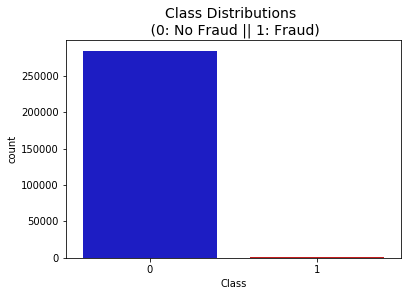

In [13]:
colors = ["#0101DF", "#DF0101"]

sns.countplot('Class', data=df, palette=colors)
plt.title('Class Distributions \n (0: No Fraud || 1: Fraud)', fontsize=14)

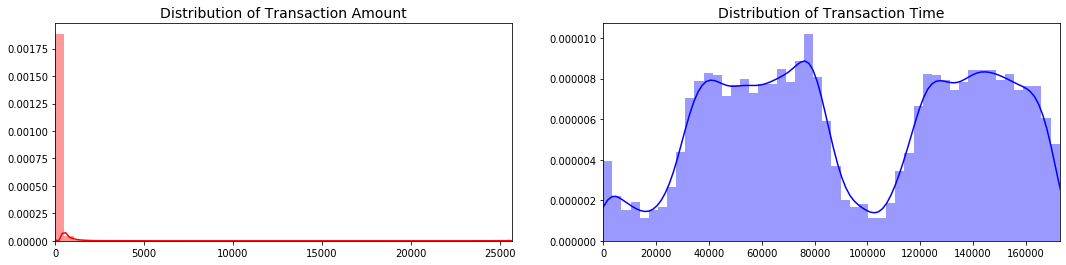

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(18,4))

amount_val = df['Amount'].values
time_val = df['Time'].values

sns.distplot(amount_val, ax=ax[0], color='r')
ax[0].set_title('Distribution of Transaction Amount', fontsize=14)
ax[0].set_xlim([min(amount_val), max(amount_val)])

sns.distplot(time_val, ax=ax[1], color='b')
ax[1].set_title('Distribution of Transaction Time', fontsize=14)
ax[1].set_xlim([min(time_val), max(time_val)])

plt.show()

In [0]:
# Since most of our data has already been scaled we should scale the columns that are left to scale (Amount and Time)
# RobustScaler is less prone to outliers.
rob_scaler = RobustScaler()

df['scaled_amount'] = rob_scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['scaled_time'] = rob_scaler.fit_transform(df['Time'].values.reshape(-1,1))

df.drop(['Time','Amount'], axis=1, inplace=True)

In [16]:
scaled_amount = df['scaled_amount']
scaled_time = df['scaled_time']

df.drop(['scaled_amount', 'scaled_time'], axis=1, inplace=True)
df.insert(0, 'scaled_amount', scaled_amount)
df.insert(1, 'scaled_time', scaled_time)

# Amount and Time are Scaled!

df.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,1.783274,-0.994983,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,-0.269825,-0.994983,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,4.983721,-0.994972,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,1.418291,-0.994972,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,0.670579,-0.994960,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0


original_Xtrain, original_ytrain, original_Xtest, original_ytest 생성(8:2)

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

print('No Frauds', round(df['Class'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Frauds', round(df['Class'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

X = df.drop('Class', axis=1)
y = df['Class']

sss = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

for train_index, test_index in sss.split(X, y):
    original_Xtrain, original_Xtest = X.iloc[train_index], X.iloc[test_index]
    original_ytrain, original_ytest = y.iloc[train_index], y.iloc[test_index]
    original_train = df.iloc[train_index]


original_Xtest_df = original_Xtest         # xgbc때문에 만들어둠

# Turn into an array
original_Xtrain = original_Xtrain.values
original_Xtest = original_Xtest.values
original_ytrain = original_ytrain.values
original_ytest = original_ytest.values

# See if both the train and test label distribution are similarly distributed
train_unique_label, train_counts_label = np.unique(original_ytrain, return_counts=True)
test_unique_label, test_counts_label = np.unique(original_ytest, return_counts=True)
print('-' * 100)

print('Label Distributions: \n')
print(train_counts_label/ len(original_ytrain))
print(test_counts_label/ len(original_ytest))

No Frauds 99.83 % of the dataset
Frauds 0.17 % of the dataset
----------------------------------------------------------------------------------------------------
Label Distributions: 

[0.99827076 0.00172924]
[0.99827952 0.00172048]


# Undersampling

Distribution of the Classes in the subsample dataset
1    0.5
0    0.5
Name: Class, dtype: float64


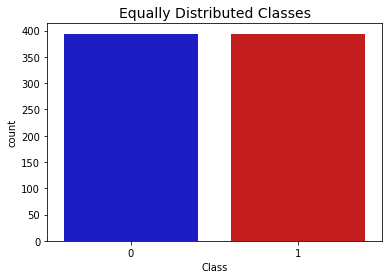

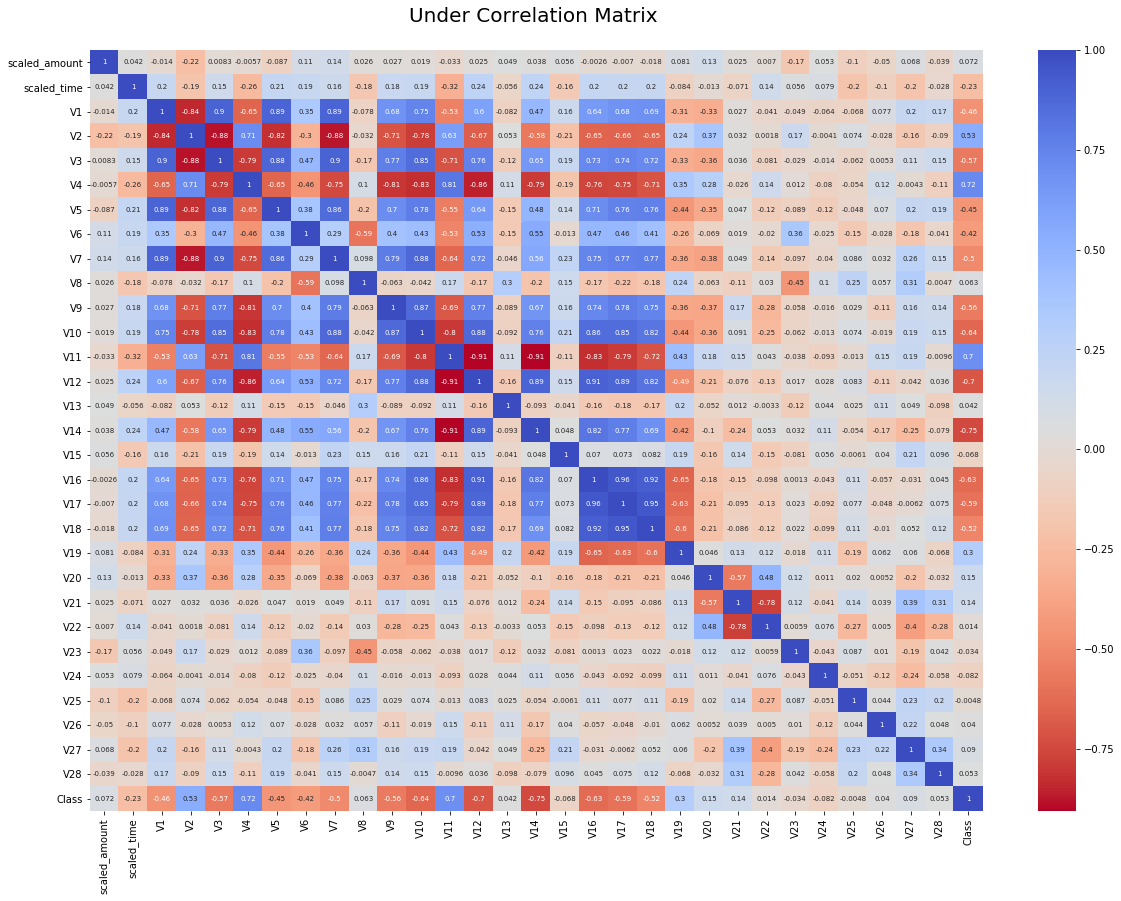

In [0]:
# Undersampling(fraud 394, non-flaud 394)으로 class와 correlation이 높은 feature 찾기

df_train = original_train.sample(frac=1, random_state=42) # shuffling before creating the subsamples

fraud_df = df_train.loc[df_train['Class'] == 1]
non_fraud_df = df_train.loc[df_train['Class'] == 0][:len(fraud_df)] #394
normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

under_df = normal_distributed_df.sample(frac=1, random_state=42) # Shuffle dataframe rows
under_df = under_df.reset_index(drop=True)
under_df.head()

print('Distribution of the Classes in the subsample dataset')
print(under_df['Class'].value_counts()/len(under_df))
sns.countplot('Class', data=under_df, palette=colors)
plt.title('Equally Distributed Classes', fontsize=14)
plt.show()

# Make sure we use the subsample in our correlation
fig = plt.figure(figsize=(20,14))
sub_sample_corr = under_df.corr()
sns.heatmap(sub_sample_corr, cmap='coolwarm_r', annot=True, annot_kws={'size':7})
plt.title('Under Correlation Matrix \n', fontsize=20)
plt.show()

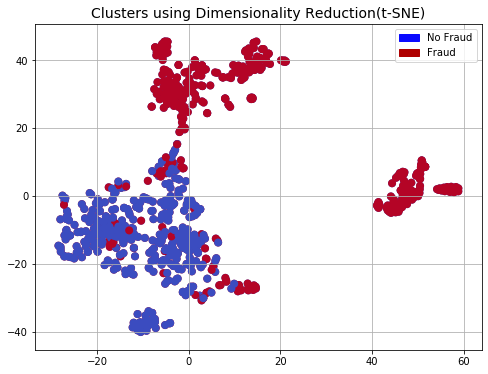

In [0]:
# T-SNE Implementation
X = under_df.drop('Class', axis=1)                                                # 이때까진 under_df은 아웃라이어가 제거되지 않은 dataframe
y = under_df['Class']

X_reduced_tsne = TSNE(n_components=2, random_state=42).fit_transform(X.values)


plt.figure(figsize=(8,6))
plt.title('Clusters using Dimensionality Reduction(t-SNE)', fontsize=14)


blue_patch = mpatches.Patch(color='#0A0AFF', label='No Fraud')
red_patch = mpatches.Patch(color='#AF0000', label='Fraud')


# t-SNE scatter plot
plt.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
plt.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)

plt.grid(True)
plt.legend(handles=[blue_patch, red_patch])


#Find highly correlated features with 'Class'

#Select 6 important features 
( V10, V12, V14, V16 for negative correlates / V4, V11 for positive correlates)


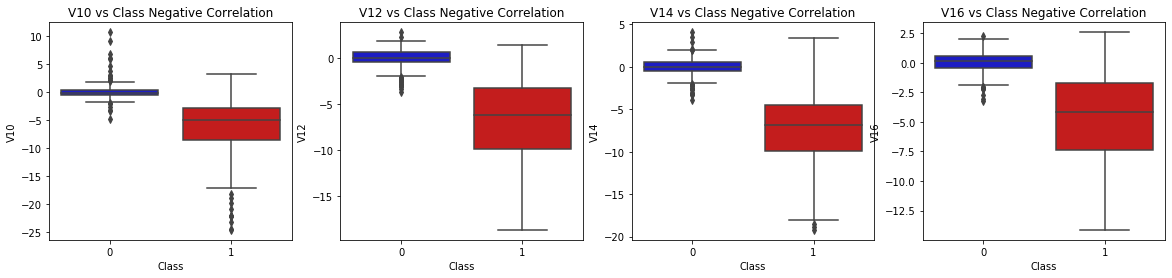

In [0]:
f, axes = plt.subplots(ncols=4, figsize=(20,4))

# Negative Correlations with our Class (The lower our feature value the more likely it will be a fraud transaction)
sns.boxplot(x="Class", y="V10", data=under_df, palette=colors, ax=axes[0])
axes[0].set_title('V10 vs Class Negative Correlation')

sns.boxplot(x="Class", y="V12", data=under_df, palette=colors, ax=axes[1])
axes[1].set_title('V12 vs Class Negative Correlation')

sns.boxplot(x="Class", y="V14", data=under_df, palette=colors, ax=axes[2])
axes[2].set_title('V14 vs Class Negative Correlation')

sns.boxplot(x="Class", y="V16", data=under_df, palette=colors, ax=axes[3])
axes[3].set_title('V16 vs Class Negative Correlation')

plt.show()

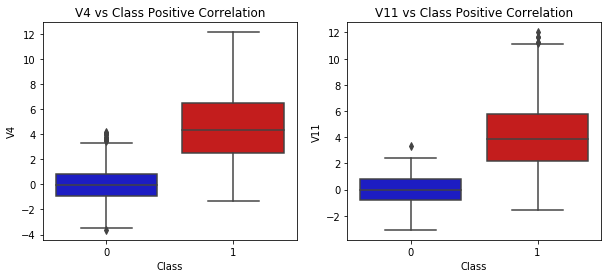

In [0]:
f, axes = plt.subplots(ncols=2, figsize=(10,4))

# Positive correlations (The higher the feature the probability increases that it will be a fraud transaction)
sns.boxplot(x="Class", y="V4", data=under_df, palette=colors, ax=axes[0])
axes[0].set_title('V4 vs Class Positive Correlation')

sns.boxplot(x="Class", y="V11", data=under_df, palette=colors, ax=axes[1])
axes[1].set_title('V11 vs Class Positive Correlation')

plt.show()


# Remove Outliers from UnderSampled Dataframe

In [0]:
outliers_neg_idx = rm_outliers_neg_1(under_df,'V10', 'V12', 'V14', 'V16')
print(outliers_neg_idx)

[ 93 209 354 396 399 404 429 470 534 578 588 678 762 767]


In [0]:
outliers_pos_idx = rm_outliers_pos_1(under_df,'V4','V11')
print(outliers_pos_idx)

[ 93 329 354 399 463]


In [0]:
outliers_neg_idx = np.array(outliers_neg_idx, dtype=int)
outliers_pos_idx = np.array(outliers_pos_idx, dtype=int)
outliers_idx = np.unique(np.concatenate((outliers_neg_idx,outliers_pos_idx)))

under_df = under_df.drop(outliers_idx)
print("%d outliers removed from undersampled dataframe" % len(outliers_idx))

16 outliers removed from undersampled dataframe


In [0]:
Under_X = under_df.drop('Class', axis=1)
Under_y = under_df['Class']

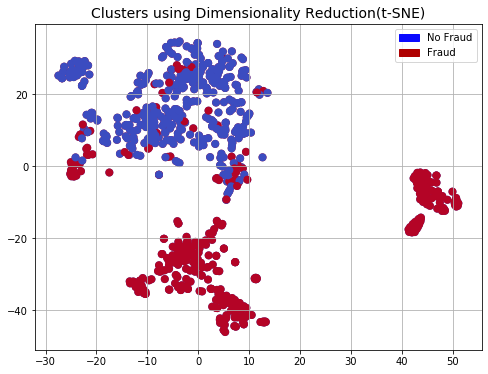

In [0]:
# T-SNE Implementation

X_reduced_tsne = TSNE(n_components=2, random_state=42).fit_transform(Under_X.values)  # Under_X는 아웃라이어가 제거된 DataFrame (772, 30)


plt.figure(figsize=(8,6))
plt.title('Clusters using Dimensionality Reduction(t-SNE)', fontsize=14)


blue_patch = mpatches.Patch(color='#0A0AFF', label='No Fraud')
red_patch = mpatches.Patch(color='#AF0000', label='Fraud')


# t-SNE scatter plot
plt.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(Under_y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
plt.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(Under_y == 1), cmap='coolwarm', label='Fraud', linewidths=2)

plt.grid(True)
plt.legend(handles=[blue_patch, red_patch])


In [0]:
f2_scorer = make_scorer(fbeta_score, beta=2)
 
 #GridSearch + cross validation fit

classifiers = {
    "LogisiticRegression": LogisticRegression(),
    "KNearest": KNeighborsClassifier(),
    "Support Vector Classifier": SVC(),
    "DecisionTreeClassifier": DecisionTreeClassifier(),
    "RandomForestClassifier": RandomForestClassifier()
}
log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
knears_params = {"n_neighbors": list(range(2,5,1)), 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}
svc_params = {'C': [0.5, 0.7, 0.9, 1], 'kernel': ['rbf', 'poly', 'sigmoid', 'linear'], 'probability': [True]}    # 'probability': [True]해줘야 predict_proba()쓸 수 있음
tree_params = {"criterion": ["gini", "entropy"], "max_depth": list(range(2,4,1)), 
              "min_samples_leaf": list(range(5,7,1))}
rf_params = {'bootstrap': [True, False], "max_depth": list(range(2,5,1)), 'max_features': ['auto'],
              "min_samples_leaf": list(range(5,7,1)), 'min_samples_split': [2, 5, 10, 15, 100], 'n_estimators': list(range(100, 1000, 100))}
cls_params = [log_reg_params, knears_params, svc_params, tree_params, rf_params]


def func_gridsearch(X, y, classifiers, cls_params):
    X = X.values; y = y.values;
  
    best_grid_lst = []
    prediction_lst = []
    pred_proba_lst = []
  
    accuracy_lst = []
    precision_lst = []
    recall_lst = []
    f1_lst = []
    f2_lst = []
    rocauc_lst = []
    prauc_lst = []
    rmse_lst = []
  
    for i, (key, classifier) in enumerate(classifiers.items()):
        grid_cls = GridSearchCV(classifier, cls_params[i], cv=5, scoring=f2_scorer)
        grid_cls.fit(X, y)
        cls = grid_cls.best_estimator_
        print('gridsearch done for {}'.format(key))
        print(cls)
        best_grid_lst.append(cls)
        cls.fit(X, y)
        prediction = cls.predict(original_Xtest)
        prediction_lst.append(prediction)
      
        accuracy_lst.append(accuracy_score(original_ytest, prediction))
        precision_lst.append(precision_score(original_ytest, prediction))
        recall_lst.append(recall_score(original_ytest, prediction))
        f1_lst.append(f1_score(original_ytest, prediction))
        f2_lst.append(fbeta_score(original_ytest, prediction, beta=2))
        rocauc_lst.append(roc_auc_score(original_ytest, prediction))
        precision, recall, _ = precision_recall_curve(original_ytest, prediction)
        prauc_lst.append(auc(recall,precision))
        rmse_lst.append(np.sqrt(mean_squared_error(original_ytest, prediction)))
        print('\n')

    return best_grid_lst, prediction_lst, pred_proba_lst, accuracy_lst, precision_lst, recall_lst, f1_lst, f2_lst, rocauc_lst, prauc_lst, rmse_lst

best_grid_lst, prediction_lst, pred_proba_lst, accuracy_lst, precision_lst, recall_lst, f1_lst, f2_lst, rocauc_lst, prauc_lst, rmse_lst = func_gridsearch(Under_X, Under_y, classifiers, cls_params) 

gridsearch done for LogisiticRegression
LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


gridsearch done for KNearest
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')


gridsearch done for Support Vector Classifier
SVC(C=0.5, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)


gridsearch done for DecisionTreeClassifier
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='en

In [0]:
print("Undersamping Evaluation Metrics Results")
print('LOG_REG','KNN', 'SVC', 'DTC', 'RFC')
print("accuracy: {}".format(accuracy_lst))
print("precision: {}".format(precision_lst))
print("recall: {}".format(recall_lst))
print("f1: {}".format(f1_lst))
print("f2: {}".format(f2_lst))
print("ROC_auc: {}".format(rocauc_lst))
print("PR_auc: {}".format(prauc_lst))
print("rmse: {}".format(rmse_lst))


Undersamping Evaluation Metrics Results
LOG_REG KNN SVC DTC RFC
accuracy: [0.9814961113744491, 0.9791085128421201, 0.9857621881638314, 0.9713663734836115, 0.9963483787152613]
precision: [0.07548845470692718, 0.06735340729001585, 0.09626274065685164, 0.049911920140927775, 0.2977941176470588]
recall: [0.8673469387755102, 0.8673469387755102, 0.8673469387755102, 0.8673469387755102, 0.826530612244898]
f1: [0.1388888888888889, 0.125, 0.1732925586136595, 0.09439200444197668, 0.43783783783783786]
f2: [0.27997364953886694, 0.2569528415961306, 0.3333333333333333, 0.20286396181384247, 0.6099397590361446]
ROC_auc: [0.924519889731388, 0.9233240330231595, 0.9266566042909434, 0.9194462917854478, 0.9115858308925103]
PR_auc: [0.4715318099063668, 0.46746428619791114, 0.481918952881329, 0.45874354262336703, 0.562311589854249]
rmse: [0.13602899920807626, 0.14453887766922763, 0.11932230234188664, 0.1692147349269218, 0.0604286462262616]


In [0]:
for i in range(0,5,1):
    print(best_grid_lst[i])
    print_metrics(original_ytest, prediction_lst[i])
    print("\n")
    

LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
---------------------------------------------------------------------------------------------------------------------------------------
accuracy: 0.9815
precision: 0.0755
recall: 0.8673
f1: 0.1389
f2: 0.2800
ROC_auc: 0.9245
rmse: 0.1360
---------------------------------------------------------------------------------------------------------------------------------------


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')
---------------------------------------------------------------------------------------------------------------

In [0]:
#Naive bayes
from sklearn.naive_bayes import GaussianNB

nbc = GaussianNB()
nbc.fit(Under_X, Under_y)
nbc_pred = nbc.predict(original_Xtest)
print_metrics(original_ytest, nbc_pred)

---------------------------------------------------------------------------------------------------------------------------------------
accuracy: 0.9757
precision: 0.0541
recall: 0.7959
f1: 0.1013
f2: 0.2126
ROC_auc: 0.8860
rmse: 0.1559
---------------------------------------------------------------------------------------------------------------------------------------


Ensemble for Undersampling

In [0]:
## Ensemble

# soft votung    (hard voting보다 soft voting이 더 좋으므로 hard voting은 생략)
# 우리가 훈련시킨 6개 분류기 중 svc만 빼고 5개를 가지고 voting_clf만들 예정임. 
# svc를 뺀 이유는, soft voting을 하려면 사용되는 분류기 모두가 predict_proba()메서드를 가지고 있어야 하는데 LinearSVC는 predict_proba()메서드를 가지고 있지 않음
# 근데 언더샘플링에서는 SVC()로 훈련시켜서 svc도 넣을 수 있음.
from sklearn.ensemble import VotingClassifier

votc = VotingClassifier(
    estimators=[('NaiveBayses', nbc), ('LogisticRegression', best_grid_lst[0]), ('KNearsNeighbors', best_grid_lst[1]), ('SupportVector', best_grid_lst[2]), ('DecisionTree', best_grid_lst[3]), ('RandomForest', best_grid_lst[4])],
    voting='soft')                                                                                                                                                                               # 보팅 방법에 소포트를 사용하면 확률을 기반으로 가장 높은 것을 예측함.
votc.fit(Under_X, Under_y)
votc_pred = votc.predict(original_Xtest)
print_metrics(original_ytest, votc_pred)

---------------------------------------------------------------------------------------------------------------------------------------
accuracy: 0.9936
precision: 0.1922
recall: 0.8571
f1: 0.3140
f2: 0.5066
ROC_auc: 0.9255
rmse: 0.0803
---------------------------------------------------------------------------------------------------------------------------------------


In [0]:
# bagging
from sklearn.ensemble import BaggingClassifier    

bagc = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,  # n_estimators: The number of base estimators in the ensemble(하나의 알고리즘으로 몇 개의 분류기를 만들 것이냐)
    max_samples=100, bootstrap=True, random_state=42)           # max_samples: 각 훈련 세트를 생성할 때 샘플 개수  # bootstrap=True로 지정해야 배깅.
bagc.fit(Under_X, Under_y)
bagc_pred = bagc.predict(original_Xtest)
print_metrics(original_ytest, bagc_pred)

---------------------------------------------------------------------------------------------------------------------------------------
accuracy: 0.9876
precision: 0.1081
recall: 0.8571
f1: 0.1920
f2: 0.3593
ROC_auc: 0.9225
rmse: 0.1114
---------------------------------------------------------------------------------------------------------------------------------------


In [0]:
# Extreme Gradient Boosting(XGBoost)

# Grid Search: 반드시 튜닝해야할 파라미터는  min_child_weight / max_depth / gamma

xgbc = XGBClassifier()
xgbc_params = {'max_depth':[7, 8],
                 'min_child_weight':[1, 3, 5],
                 'gamma':[0, 1, 2],
                 'n_jobs':[-1],
                 'random_state':[42]}


gcv=GridSearchCV(xgbc, param_grid=xgbc_params, n_jobs=-1, cv=5, scoring=f2_scorer)
gcv.fit(Under_X, Under_y)
gcv.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=1,
              learning_rate=0.1, max_delta_step=0, max_depth=7,
              min_child_weight=3, missing=None, n_estimators=100, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [0]:
xgbc = gcv.best_estimator_
xgbc.fit(Under_X, Under_y)

xgbc_pred = xgbc.predict(original_Xtest_df)                                     
print_metrics(original_ytest, xgbc_pred)

---------------------------------------------------------------------------------------------------------------------------------------
accuracy: 0.9904
precision: 0.1392
recall: 0.8776
f1: 0.2402
f2: 0.4257
ROC_auc: 0.9341
rmse: 0.0977
---------------------------------------------------------------------------------------------------------------------------------------


undersampling시 train set의 크기는 772개이다(Fraud:394-16 + NonFraud:394).  그리드서치 후 나오는 best_estimator_는 772개의 80%만을 가지고 학습하여 나온 estimator이다. train set의 크기가 작아 모델에 학습시키는 데이터 하나하나가 소중하므로 그리드서치에서 찾은 최적 하이퍼파라미터로 모델을 다시 구성하고 전체 train set으로 학습시키자.



In [0]:
nbc = GaussianNB()

nbc.fit(Under_X, Under_y)
nbc_pred = nbc.predict(original_Xtest)
print_metrics(original_ytest, nbc_pred)

---------------------------------------------------------------------------------------------------------------------------------------
accuracy: 0.9757
precision: 0.0541
recall: 0.7959
f1: 0.1013
f2: 0.2126
ROC_auc: 0.8860
rmse: 0.1559
---------------------------------------------------------------------------------------------------------------------------------------


In [0]:
log_reg = LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

log_reg.fit(Under_X, Under_y)
log_reg_pred = log_reg.predict(original_Xtest)
print_metrics(original_ytest, log_reg_pred)

---------------------------------------------------------------------------------------------------------------------------------------
accuracy: 0.9815
precision: 0.0755
recall: 0.8673
f1: 0.1389
f2: 0.2800
ROC_auc: 0.9245
rmse: 0.1360
---------------------------------------------------------------------------------------------------------------------------------------


In [0]:
knn = KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

knn.fit(Under_X, Under_y)
knn_pred = knn.predict(original_Xtest)
print_metrics(original_ytest, knn_pred)

---------------------------------------------------------------------------------------------------------------------------------------
accuracy: 0.9791
precision: 0.0674
recall: 0.8673
f1: 0.1250
f2: 0.2570
ROC_auc: 0.9233
rmse: 0.1445
---------------------------------------------------------------------------------------------------------------------------------------


In [0]:
svc = SVC(C=0.5, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

svc.fit(Under_X, Under_y)
svc_pred = svc.predict(original_Xtest)
print_metrics(original_ytest, svc_pred)

---------------------------------------------------------------------------------------------------------------------------------------
accuracy: 0.9858
precision: 0.0963
recall: 0.8673
f1: 0.1733
f2: 0.3333
ROC_auc: 0.9267
rmse: 0.1193
---------------------------------------------------------------------------------------------------------------------------------------


In [0]:
dtc = DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

dtc.fit(Under_X, Under_y)
dtc_pred = dtc.predict(original_Xtest)
print_metrics(original_ytest, dtc_pred)

---------------------------------------------------------------------------------------------------------------------------------------
accuracy: 0.9714
precision: 0.0499
recall: 0.8673
f1: 0.0944
f2: 0.2029
ROC_auc: 0.9194
rmse: 0.1692
---------------------------------------------------------------------------------------------------------------------------------------


In [0]:
rfc = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=4, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=15,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

rfc.fit(Under_X, Under_y)
rfc_pred = rfc.predict(original_Xtest)
print_metrics(original_ytest, rfc_pred)

---------------------------------------------------------------------------------------------------------------------------------------
accuracy: 0.9972
precision: 0.3600
recall: 0.8265
f1: 0.5015
f2: 0.6564
ROC_auc: 0.9120
rmse: 0.0532
---------------------------------------------------------------------------------------------------------------------------------------


In [0]:
votc = VotingClassifier(
    estimators=[('NaiveBayses', nbc), ('LogisticRegression', log_reg), ('KNearsNeighbors', knn), ('SupportVector', svc), ('DecisionTree', dtc), ('RandomForest', rfc)],
    voting='soft')

votc.fit(Under_X, Under_y)
votc_pred = votc.predict(original_Xtest)
print_metrics(original_ytest, votc_pred)

---------------------------------------------------------------------------------------------------------------------------------------
accuracy: 0.9938
precision: 0.1976
recall: 0.8571
f1: 0.3212
f2: 0.5141
ROC_auc: 0.9256
rmse: 0.0789
---------------------------------------------------------------------------------------------------------------------------------------


In [0]:
bagc = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500, 
    max_samples=100, bootstrap=True, random_state=42)

bagc.fit(Under_X, Under_y)
bagc_pred = bagc.predict(original_Xtest)
print_metrics(original_ytest, bagc_pred)

---------------------------------------------------------------------------------------------------------------------------------------
accuracy: 0.9876
precision: 0.1081
recall: 0.8571
f1: 0.1920
f2: 0.3593
ROC_auc: 0.9225
rmse: 0.1114
---------------------------------------------------------------------------------------------------------------------------------------


In [0]:
xgbc = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=1,
              learning_rate=0.1, max_delta_step=0, max_depth=7,
              min_child_weight=3, missing=None, n_estimators=100, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

xgbc.fit(Under_X, Under_y)
xgbc_pred = xgbc.predict(original_Xtest_df)
print_metrics(original_ytest, xgbc_pred)

---------------------------------------------------------------------------------------------------------------------------------------
accuracy: 0.9904
precision: 0.1392
recall: 0.8776
f1: 0.2402
f2: 0.4257
ROC_auc: 0.9341
rmse: 0.0977
---------------------------------------------------------------------------------------------------------------------------------------


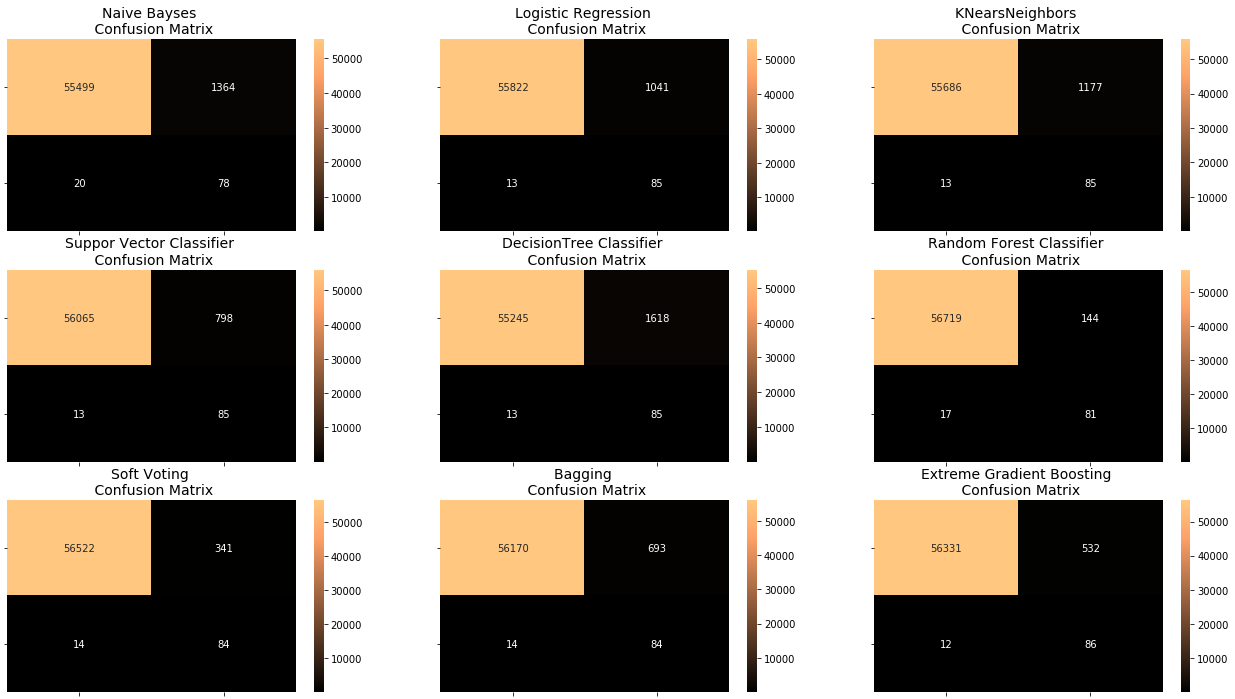

In [0]:
plot_confusion_matrix(original_ytest, nbc_pred, log_reg_pred, knn_pred, svc_pred, dtc_pred, rfc_pred, votc_pred, bagc_pred, xgbc_pred)

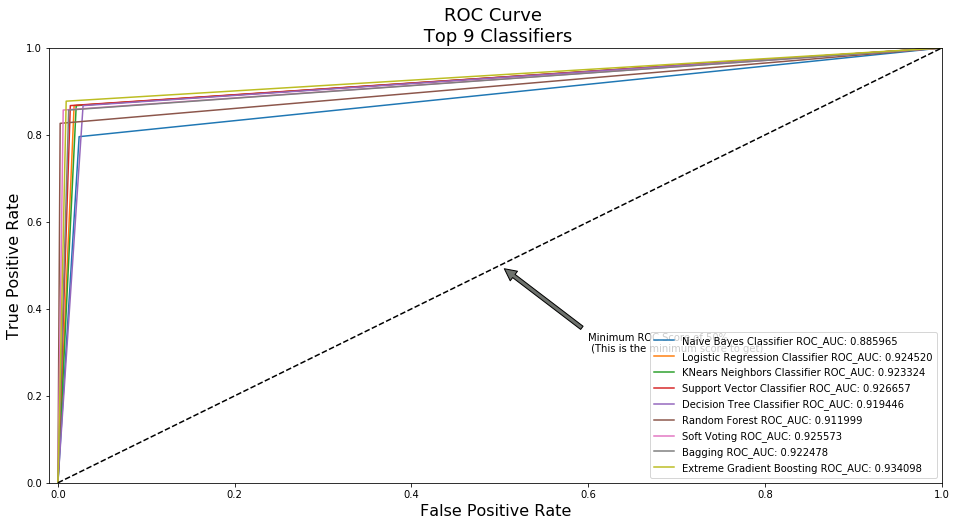

In [0]:
plot_roc_curve(original_ytest, nbc_pred, log_reg_pred, knn_pred, svc_pred, dtc_pred, rfc_pred, votc_pred, bagc_pred, xgbc_pred)

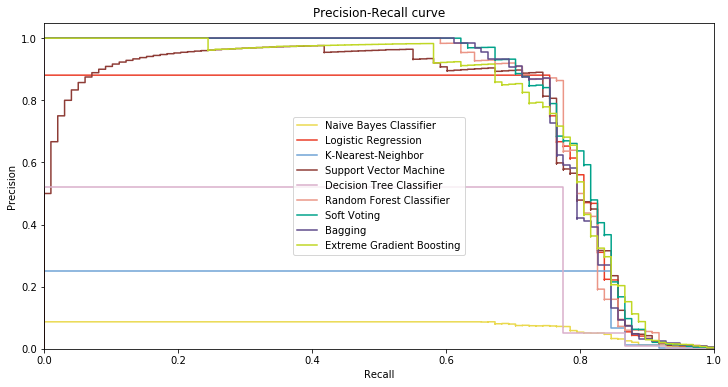

Area Under PR Curve of Naive Bayes Classifier: 0.37
Area Under PR Curve of Logistic Regression: 0.76
Area Under PR Curve of K-Nearest-Neighbor: 0.54
Area Under PR Curve of Support Vector Machine: 0.74
Area Under PR Curve of Decision Tree Classifier: 0.61
Area Under PR Curve of Random Forest Classifier: 0.80
Area Under PR Curve of Soft Voting: 0.81
Area Under PR Curve of Bagging: 0.79
Area Under PR Curve of Extreme Gradient Boosting: 0.78


In [0]:
plot_precision_recall_curve(original_Xtest, original_ytest, nbc, log_reg, knn, svc, dtc, rfc, votc, bagc, xgbc)

##  OverSampling

In [18]:
df

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,1.783274,-0.994983,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,-0.269825,-0.994983,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,4.983721,-0.994972,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,1.418291,-0.994972,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,0.670579,-0.994960,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,-0.296653,1.034951,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,4.356170,-1.593105,2.711941,-0.689256,4.626942,-0.924459,1.107641,1.991691,0.510632,-0.682920,1.475829,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0
284803,0.038986,1.034963,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,-0.150189,0.915802,1.214756,-0.675143,1.164931,-0.711757,-0.025693,-1.221179,-1.545556,0.059616,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,0
284804,0.641096,1.034975,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,0.411614,0.063119,-0.183699,-0.510602,1.329284,0.140716,0.313502,0.395652,-0.577252,0.001396,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,0
284805,-0.167680,1.034975,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,-1.933849,-0.962886,-1.042082,0.449624,1.962563,-0.608577,0.509928,1.113981,2.897849,0.127434,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,0


In [0]:
## 1. original train set에서 아웃라이어 제거 먼저 하기
X = df.drop('Class', axis=1)
y = df['Class']

sss = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

for train_index, test_index in sss.split(X, y):
    original_Xtrain, original_Xtest = X.iloc[train_index], X.iloc[test_index]
    original_ytrain, original_ytest = y.iloc[train_index], y.iloc[test_index]
    original_train = df.iloc[train_index]


original_Xtest_df = original_Xtest     # xgbc때문에 만들어둠

# Turn into an array
original_Xtrain = original_Xtrain.values
original_Xtest = original_Xtest.values
original_ytrain = original_ytrain.values
original_ytest = original_ytest.values


In [20]:
outliers_neg_idx = rm_outliers_neg_1(original_train,'V10', 'V12', 'V14', 'V16')
print(outliers_neg_idx)

[  8296   8615   9035  44270 151006 151007 151008 151009 153823 153835
 154234 154371 154587 154684]


In [21]:
outliers_pos_idx = rm_outliers_pos_1(original_train,'V4','V11')
print(outliers_pos_idx)

[8296 8615 9035 9252 9487]


In [22]:
outliers_neg_idx = np.array(outliers_neg_idx, dtype=int)
outliers_pos_idx = np.array(outliers_pos_idx, dtype=int)
outliers_idx = np.unique(np.concatenate((outliers_neg_idx,outliers_pos_idx)))

original_train_rm = original_train.drop(outliers_idx)
print("%d outliers removed from undersampled dataframe" % len(outliers_idx))

16 outliers removed from undersampled dataframe


In [0]:
original_Xtrain_rm = original_train_rm.drop('Class', axis=1)
original_ytrain_rm = original_train_rm['Class']

In [0]:
# Turn into an array
original_Xtrain_rm = original_Xtrain_rm.values
original_ytrain_rm = original_ytrain_rm.values

In [0]:
## 2. 아웃라이어가 제거된 original train set을 가지고 cross validation하면서 oversampling하기
# 이를 위해 imblearn패키지의 Pipeline 사용
# The imblearn pipeline will only call sample() method on training data and not on test data. The test data will be passed through without any changes. 
# It resamples only when fit is called, not when predict is called.

from imblearn.pipeline import Pipeline


sm = SMOTE(sampling_strategy='minority', random_state=42)


log_reg_params = {"classification__penalty": ['l1', 'l2'], 'classification__C': [0.1, 1, 10, 100]}

model = Pipeline([
        ('sampling', sm),
        ('classification', LogisticRegression())
    ])

grid = GridSearchCV(model, log_reg_params, n_jobs=-1)
grid.fit(original_Xtrain_rm, original_ytrain_rm)
log_reg = grid.best_estimator_
log_reg

Pipeline(memory=None,
         steps=[('sampling',
                 SMOTE(k_neighbors=5, kind='deprecated',
                       m_neighbors='deprecated', n_jobs=1,
                       out_step='deprecated', random_state=42, ratio=None,
                       sampling_strategy='minority',
                       svm_estimator='deprecated')),
                ('classification',
                 LogisticRegression(C=0.1, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [0]:
knears_params = {'classification__algorithm': ['auto']}

model = Pipeline([
        ('sampling', sm),
        ('classification', KNeighborsClassifier())
    ])

grid = GridSearchCV(model, knears_params, n_jobs=-1)
grid.fit(original_Xtrain, original_ytrain)
knn = grid.best_estimator_
knn

Pipeline(memory=None,
         steps=[('sampling',
                 SMOTE(k_neighbors=5, kind='deprecated',
                       m_neighbors='deprecated', n_jobs=1,
                       out_step='deprecated', random_state=42, ratio=None,
                       sampling_strategy='minority',
                       svm_estimator='deprecated')),
                ('classification',
                 KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                      metric='minkowski', metric_params=None,
                                      n_jobs=None, n_neighbors=5, p=2,
                                      weights='uniform'))],
         verbose=False)

In [0]:
svc_params = {'classification__C': [0.1, 1, 10]}

model = Pipeline([
        ('sampling', sm),
        ('classification', LinearSVC())
    ])

grid = GridSearchCV(model, svc_params, n_jobs=-1)
grid.fit(original_Xtrain_rm, original_ytrain_rm)
svc = grid.best_estimator_
svc

Pipeline(memory=None,
         steps=[('sampling',
                 SMOTE(k_neighbors=5, kind='deprecated',
                       m_neighbors='deprecated', n_jobs=1,
                       out_step='deprecated', random_state=42, ratio=None,
                       sampling_strategy='minority',
                       svm_estimator='deprecated')),
                ('classification',
                 LinearSVC(C=0.1, class_weight=None, dual=True,
                           fit_intercept=True, intercept_scaling=1,
                           loss='squared_hinge', max_iter=1000,
                           multi_class='ovr', penalty='l2', random_state=None,
                           tol=0.0001, verbose=0))],
         verbose=False)

In [0]:
tree_params = {"classification__criterion": ["gini", "entropy"], "classification__max_depth": [2, 3], 
              "classification__min_samples_leaf": [5, 6]}

model = Pipeline([
        ('sampling', sm),
        ('classification', DecisionTreeClassifier())
    ])

grid = GridSearchCV(model, tree_params, n_jobs=-1)
grid.fit(original_Xtrain_rm, original_ytrain_rm)
dtc = grid.best_estimator_
dtc

Pipeline(memory=None,
         steps=[('sampling',
                 SMOTE(k_neighbors=5, kind='deprecated',
                       m_neighbors='deprecated', n_jobs=1,
                       out_step='deprecated', random_state=42, ratio=None,
                       sampling_strategy='minority',
                       svm_estimator='deprecated')),
                ('classification',
                 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                        criterion='entropy', max_depth=2,
                                        max_features=None, max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=5, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        presort='deprecated', random_state=None,
                         

In [0]:
rf_params = {'classification__bootstrap': [True], "classification__criterion": ["gini"], 'classification__max_features': [6],
              "classification__max_leaf_nodes": [16], 'classification__n_estimators': [100]}

model = Pipeline([
        ('sampling', sm),
        ('classification', RandomForestClassifier())
    ])

grid = GridSearchCV(model, rf_params, n_jobs=-1)
grid.fit(original_Xtrain_rm, original_ytrain_rm)
rfc = grid.best_estimator_      
rfc 

Pipeline(memory=None,
         steps=[('sampling',
                 SMOTE(k_neighbors=5, kind='deprecated',
                       m_neighbors='deprecated', n_jobs=1,
                       out_step='deprecated', random_state=42, ratio=None,
                       sampling_strategy='minority',
                       svm_estimator='deprecated')),
                ('classification',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features=6,
                                        max_leaf_nodes=16, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                     

In [0]:
xgbc_params = {'classification__max_depth':[8],                                 # 1시간 30분 걸림
               'classification__min_child_weight':[1,3],
               'classification__gamma':[0,1],
               'classification__n_jobs':[-1]}

model = Pipeline([
        ('sampling', sm),
        ('classification', XGBClassifier())
    ])



grid = GridSearchCV(model, xgbc_params, n_jobs=-1)
grid.fit(original_Xtrain_rm, original_ytrain_rm)
xgbc = grid.best_estimator_      
xgbc 

Pipeline(memory=None,
         steps=[('sampling',
                 SMOTE(k_neighbors=5, kind='deprecated',
                       m_neighbors='deprecated', n_jobs=1,
                       out_step='deprecated', random_state=42, ratio=None,
                       sampling_strategy='minority',
                       svm_estimator='deprecated')),
                ('classification',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=1, learning_rate=0.1,
                               max_delta_step=0, max_depth=8,
                               min_child_weight=1, missing=None,
                               n_estimators=100, n_jobs=-1, nthread=None,
                               objective='binary:logistic', random_state=0,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               seed=None, sile

In [0]:
## 3. 이제 test set을 넣어 맞춰보자!
# nbc, soft voting, bagging도 학습시키기 위해 아웃라이어 제거된 원본데이터를 SMOTE하여 train set 만듦.

X_resampled, y_resampled = sm.fit_sample(original_Xtrain_rm, original_ytrain_rm)
X_resampled = pd.DataFrame(data=X_resampled)
y_resampled = pd.DataFrame(data=y_resampled)
X_resampled.columns = ['scaled_amount', 'scaled_time', 'V1', 'V2', 'V3', 'V4', 'V5','V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28']
y_resampled.columns = ['Class']
normal_distributed_df = pd.concat([X_resampled, y_resampled], axis=1)

# Shuffle dataframe rows
over_df = normal_distributed_df.sample(frac=1, random_state=42)
over_df = over_df.reset_index(drop=True)

Over_X = over_df.drop('Class', axis=1)
Over_y = over_df['Class']


In [36]:
# NBC
from sklearn.naive_bayes import GaussianNB

nbc = GaussianNB()
nbc.fit(Over_X.values, Over_y.values)
nbc_pred = nbc.predict(original_Xtest)

print(nbc)
print_metrics(original_ytest, nbc_pred)

GaussianNB(priors=None, var_smoothing=1e-09)
---------------------------------------------------------------------------------------------------------------------------------------
accuracy: 0.9797
precision: 0.0649
recall: 0.8061
f1: 0.1201
f2: 0.2453
ROC_auc: 0.8930
rmse: 0.1426
---------------------------------------------------------------------------------------------------------------------------------------


In [0]:
# Logistic Regression
log_reg_pred = log_reg.predict(original_Xtest)

print(log_reg)
print_metrics(original_ytest, log_reg_pred)

Pipeline(memory=None,
         steps=[('sampling',
                 SMOTE(k_neighbors=5, kind='deprecated',
                       m_neighbors='deprecated', n_jobs=1,
                       out_step='deprecated', random_state=42, ratio=None,
                       sampling_strategy='minority',
                       svm_estimator='deprecated')),
                ('classification',
                 LogisticRegression(C=0.1, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)
-----------------------------------------------------------------------------------------------------------

In [0]:
# KNN
knn_pred = knn.predict(original_Xtest)

print(knn)
print_metrics(original_ytest, knn_pred)

Pipeline(memory=None,
         steps=[('sampling',
                 SMOTE(k_neighbors=5, kind='deprecated',
                       m_neighbors='deprecated', n_jobs=1,
                       out_step='deprecated', random_state=42, ratio=None,
                       sampling_strategy='minority',
                       svm_estimator='deprecated')),
                ('classification',
                 KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                      metric='minkowski', metric_params=None,
                                      n_jobs=None, n_neighbors=5, p=2,
                                      weights='uniform'))],
         verbose=False)
---------------------------------------------------------------------------------------------------------------------------------------
accuracy: 0.9985
precision: 0.5524
recall: 0.8061
f1: 0.6556
f2: 0.7383
ROC_auc: 0.9025
rmse: 0.0382
-----------------------------------------------------------------------------

In [57]:
# SVM
svc_pred = svc.predict(original_Xtest)

print(svc)
print_metrics(original_ytest, svc_pred)

Pipeline(memory=None,
         steps=[('sampling',
                 SMOTE(k_neighbors=5, kind='deprecated',
                       m_neighbors='deprecated', n_jobs=1,
                       out_step='deprecated', random_state=42, ratio=None,
                       sampling_strategy='minority',
                       svm_estimator='deprecated')),
                ('classification',
                 LinearSVC(C=0.1, class_weight=None, dual=True,
                           fit_intercept=True, intercept_scaling=1,
                           loss='squared_hinge', max_iter=1000,
                           multi_class='ovr', penalty='l2', random_state=None,
                           tol=0.0001, verbose=0))],
         verbose=False)
---------------------------------------------------------------------------------------------------------------------------------------
accuracy: 0.9875
precision: 0.1074
recall: 0.8571
f1: 0.1909
f2: 0.3578
ROC_auc: 0.9224
rmse: 0.1118
----------------------------

In [0]:
# DecisionTree
dtc_pred = dtc.predict(original_Xtest)

print(dtc)
print_metrics(original_ytest, dtc_pred)

Pipeline(memory=None,
         steps=[('sampling',
                 SMOTE(k_neighbors=5, kind='deprecated',
                       m_neighbors='deprecated', n_jobs=1,
                       out_step='deprecated', random_state=42, ratio=None,
                       sampling_strategy='minority',
                       svm_estimator='deprecated')),
                ('classification',
                 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                        criterion='entropy', max_depth=2,
                                        max_features=None, max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=5, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        presort='deprecated', random_state=None,
                         

In [58]:
# RandomForest
rfc_pred = rfc.predict(original_Xtest)

print(rfc)
print_metrics(original_ytest, rfc_pred)

Pipeline(memory=None,
         steps=[('sampling',
                 SMOTE(k_neighbors=5, kind='deprecated',
                       m_neighbors='deprecated', n_jobs=1,
                       out_step='deprecated', random_state=42, ratio=None,
                       sampling_strategy='minority',
                       svm_estimator='deprecated')),
                ('classification',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features=6,
                                        max_leaf_nodes=16, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                     

In [42]:
# Soft Voting
from sklearn.ensemble import VotingClassifier

votc = VotingClassifier(
    estimators=[('NaiveBayses', nbc), ('LogisticRegression', log_reg), ('KNearsNeighbors', knn), ('DecisionTree', dtc), ('RandomForest', rfc)],
    voting='soft')
votc.fit(Over_X.values, Over_y.values)   
votc_pred = votc.predict(original_Xtest)

print(votc)
print_metrics(original_ytest, votc_pred)

VotingClassifier(estimators=[('NaiveBayses',
                              GaussianNB(priors=None, var_smoothing=1e-09)),
                             ('LogisticRegression',
                              Pipeline(memory=None,
                                       steps=[('sampling',
                                               SMOTE(k_neighbors=5,
                                                     kind='deprecated',
                                                     m_neighbors='deprecated',
                                                     n_jobs=1,
                                                     out_step='deprecated',
                                                     random_state=42,
                                                     ratio=None,
                                                     sampling_strategy='minority',
                                                     svm_estimator='deprecated')),
                                              ('classifi

In [44]:
# Bagging
from sklearn.ensemble import BaggingClassifier    

bagc = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,                                                                                  # n_estimators: The number of base estimators in the ensemble(하나의 알고리즘으로 몇 개의 분류기를 만들 것이냐)
    max_samples=100, bootstrap=True, random_state=42)                                                                                           # max_samples: 각 훈련 세트를 생성할 때 샘플 개수  # bootstrap=True로 지정해야 배깅.
bagc.fit(Over_X.values, Over_y.values)
bagc_pred = bagc.predict(original_Xtest)

print(bagc)
print_metrics(original_ytest, bagc_pred)

BaggingClassifier(base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                        class_weight=None,
                                                        criterion='gini',
                                                        max_depth=None,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
                                                        presort='deprecated',
                                                        random_state=42,
  

In [0]:
# Xgboost
xgbc_pred = xgbc.predict(original_Xtest)

print(xgbc)
print_metrics(original_ytest, xgbc_pred)

Pipeline(memory=None,
         steps=[('sampling',
                 SMOTE(k_neighbors=5, kind='deprecated',
                       m_neighbors='deprecated', n_jobs=1,
                       out_step='deprecated', random_state=42, ratio=None,
                       sampling_strategy='minority',
                       svm_estimator='deprecated')),
                ('classification',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=1, learning_rate=0.1,
                               max_delta_step=0, max_depth=8,
                               min_child_weight=1, missing=None,
                               n_estimators=100, n_jobs=-1, nthread=None,
                               objective='binary:logistic', random_state=0,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               seed=None, sile

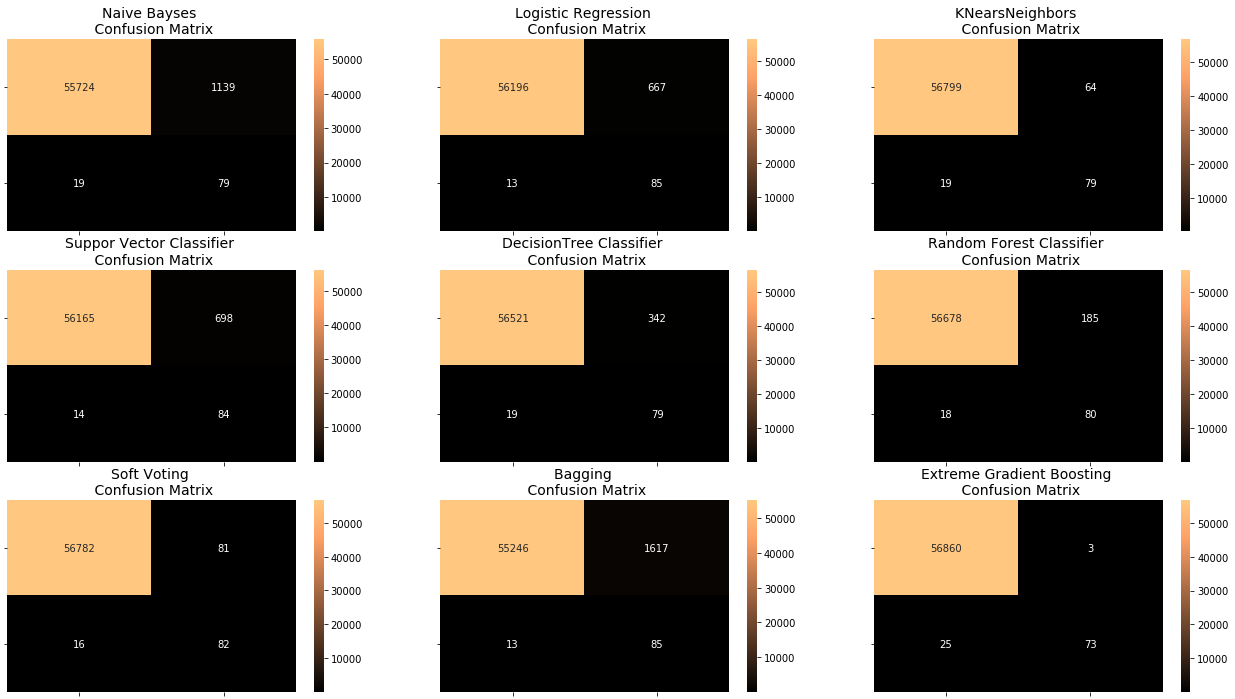

In [52]:
plot_confusion_matrix(original_ytest, nbc_pred, log_reg_pred, knn_pred, svc_pred, dtc_pred, rfc_pred, votc_pred, bagc_pred, xgbc_pred)

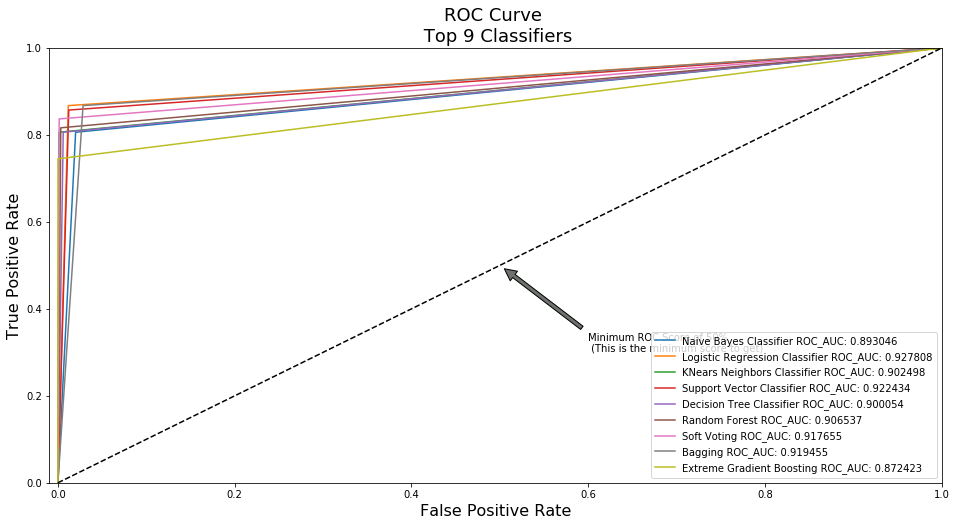

In [53]:
plot_roc_curve(original_ytest, nbc_pred, log_reg_pred, knn_pred, svc_pred, dtc_pred, rfc_pred, votc_pred, bagc_pred, xgbc_pred)

마지막으로, undersampling에서 했던 것처럼 plot_precision_recall_curve(original_Xtest, original_ytest, nbc, log_reg, knn, svc, dtc, rfc, votc, bagc, xgbc) 해보면 feature_names mismatch 오류가 뜬다. undersampling할 때는 에러가 안 떴었는데 지금은 왜 뜰까? 이유는 xgbc때문이다. 맨 위에서 정의한 plot_precision_recall_curve()과 아래에서 정의한 plot_precision_recall_curve_ov()의 함수 코드 내에 #####으로 표시해둔 부분만 다름을 확인해보길 바람.(xgboost패키지의 버그 중 하나. 자세한 설명은 아래 링크를 참고)
https://stackoverflow.com/questions/42338972/valueerror-feature-names-mismatch-in-xgboost-in-the-predict-function 

In [0]:
# oversampling에서 xgbc때문에 만든 plot_precision_recall_curve_ov() 

def plot_precision_recall_curve_ov(original_Xtest, original_ytest, nbc, log_reg, knn, svc, dtc, rfc, votc, bagc, xgbc):          

    nbc_proba_value_ytest = nbc.predict_proba(original_Xtest)[:, 1]
    log_reg_proba_value_ytest = log_reg.predict_proba(original_Xtest)[:, 1]
    knn_proba_value_ytest = knn.predict_proba(original_Xtest)[:, 1]
    svc_decision_func_value_ytest = svc.decision_function(original_Xtest)       # precision_recall_curve()에 estimated probabilities 또는 decision function값을 넣어줘야 하는데 svc는 decision function만 메소드로 제공
    dtc_proba_value_ytest = dtc.predict_proba(original_Xtest)[:, 1]
    rfc_proba_value_ytest = rfc.predict_proba(original_Xtest)[:, 1]
    votc_proba_value_ytest = votc.predict_proba(original_Xtest)[:, 1]
    bagc_proba_value_ytest = bagc.predict_proba(original_Xtest)[:, 1]
    xgbc_proba_value_ytest = xgbc.predict_proba(original_Xtest)[:,1]            ##### original_Xtest에 주의. oversampling에서 xgbc때문임.           
    
    
    fig = plt.figure(figsize=(12,6))
    
    nbc_precision, nbc_recall, nbc_thresholds = precision_recall_curve(original_ytest, nbc_proba_value_ytest)      # precision_recall_curve(y_true, estimated probabilities 또는 decision function)의  return: precision, recall ,thresholds
    log_reg_precision, log_reg_recall, log_reg_thresholds = precision_recall_curve(original_ytest, log_reg_proba_value_ytest)  
    knn_precision, knn_recall, knn_thresholds = precision_recall_curve(original_ytest, knn_proba_value_ytest)  
    svc_precision, svc_recall, svc_thresholds = precision_recall_curve(original_ytest, svc_decision_func_value_ytest)  
    dtc_precision, dtc_recall, dtc_thresholds = precision_recall_curve(original_ytest, dtc_proba_value_ytest)  
    rfc_precision, rfc_recall, rfc_thresholds = precision_recall_curve(original_ytest, rfc_proba_value_ytest)  
    votc_precision, votc_recall, votc_thresholds = precision_recall_curve(original_ytest, votc_proba_value_ytest)      # precision_recall_curve(y_true, estimated probabilities 또는 decision function)   의 return: precision, recall ,thresholds
    bagc_precision, bagc_recall, bagc_thresholds = precision_recall_curve(original_ytest, bagc_proba_value_ytest)  
    xgbc_precision, xgbc_recall, xgbc_thresholds = precision_recall_curve(original_ytest, xgbc_proba_value_ytest)  
     
    
    plt.step(nbc_recall, nbc_precision, label="Naive Bayes Classifier", color='#ead94e', where='post')
    plt.step(log_reg_recall, log_reg_precision, label="Logistic Regression", color='#eb3c27', where='post')
    plt.step(knn_recall, knn_precision, label="K-Nearest-Neighbor", color='#6ea2d5', where='post')
    plt.step(svc_recall, svc_precision, label="Support Vector Machine", color='#8e3c36', where='post')
    plt.step(dtc_recall, dtc_precision, label="Decision Tree Classifier", color='#d9afca', where='post')
    plt.step(rfc_recall, rfc_precision, label="Random Forest Classifier", color='#eb9687', where='post')
    plt.step(votc_recall, votc_precision, label="Soft Voting", color='#00a28a', where='post')
    plt.step(bagc_recall, bagc_precision, label="Bagging", color='#5f4b8b', where='post')
    plt.step(xgbc_recall, xgbc_precision, label="Extreme Gradient Boosting", color='#c0d725', where='post')
    
    
    
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall curve')
    plt.legend()
    plt.show()
    
    
    # PR curve 아래 면적 계산하기(AUPRC)
    
    nbc_area = auc(nbc_recall, nbc_precision)
    log_reg_area = auc(log_reg_recall, log_reg_precision)
    knn_area = auc(knn_recall, knn_precision)
    svc_area = auc(svc_recall, svc_precision)
    dtc_area = auc(dtc_recall, dtc_precision)
    rfc_area = auc(rfc_recall, rfc_precision)
    votc_area = auc(votc_recall, votc_precision)
    bagc_area = auc(bagc_recall, bagc_precision)
    xgbc_area = auc(xgbc_recall, xgbc_precision)
    
    print("Area Under PR Curve of Naive Bayes Classifier: %0.2f" % nbc_area)  
    print("Area Under PR Curve of Logistic Regression: %0.2f" % log_reg_area)
    print("Area Under PR Curve of K-Nearest-Neighbor: %0.2f" % knn_area)
    print("Area Under PR Curve of Support Vector Machine: %0.2f" % svc_area)
    print("Area Under PR Curve of Decision Tree Classifier: %0.2f" % dtc_area)
    print("Area Under PR Curve of Random Forest Classifier: %0.2f" % rfc_area)
    print("Area Under PR Curve of Soft Voting: %0.2f" % votc_area)  
    print("Area Under PR Curve of Bagging: %0.2f" % bagc_area)
    print("Area Under PR Curve of Extreme Gradient Boosting: %0.2f" % xgbc_area)

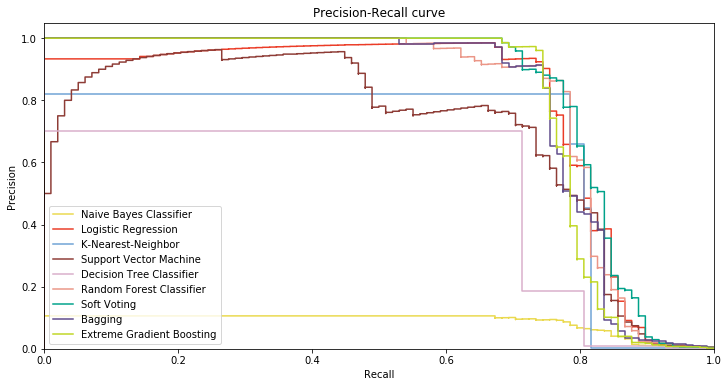

Area Under PR Curve of Naive Bayes Classifier: 0.39
Area Under PR Curve of Logistic Regression: 0.79
Area Under PR Curve of K-Nearest-Neighbor: 0.78
Area Under PR Curve of Support Vector Machine: 0.69
Area Under PR Curve of Decision Tree Classifier: 0.66
Area Under PR Curve of Random Forest Classifier: 0.80
Area Under PR Curve of Soft Voting: 0.82
Area Under PR Curve of Bagging: 0.79
Area Under PR Curve of Extreme Gradient Boosting: 0.79


In [55]:
plot_precision_recall_curve_ov(original_Xtest, original_ytest, nbc, log_reg, knn, svc, dtc, rfc, votc, bagc, xgbc)  

참고)단순 궁금증: Soft Voting Classifier에 Bagging이랑 XGBoost까지 다 넣으면 어떤 결과가 나올까?

In [56]:
votc2 = VotingClassifier(
    estimators=[('NaiveBayses', nbc), ('LogisticRegression', log_reg), ('KNearsNeighbors', knn), ('DecisionTree', dtc), ('RandomForest', rfc), ('Bagging', bagc), ('XGBoost', xgbc)],
    voting='soft')
votc2.fit(Over_X.values, Over_y.values)   
votc2_pred = votc2.predict(original_Xtest)

print(votc2)
print_metrics(original_ytest, votc2_pred)

VotingClassifier(estimators=[('NaiveBayses',
                              GaussianNB(priors=None, var_smoothing=1e-09)),
                             ('LogisticRegression',
                              Pipeline(memory=None,
                                       steps=[('sampling',
                                               SMOTE(k_neighbors=5,
                                                     kind='deprecated',
                                                     m_neighbors='deprecated',
                                                     n_jobs=1,
                                                     out_step='deprecated',
                                                     random_state=42,
                                                     ratio=None,
                                                     sampling_strategy='minority',
                                                     svm_estimator='deprecated')),
                                              ('classifi

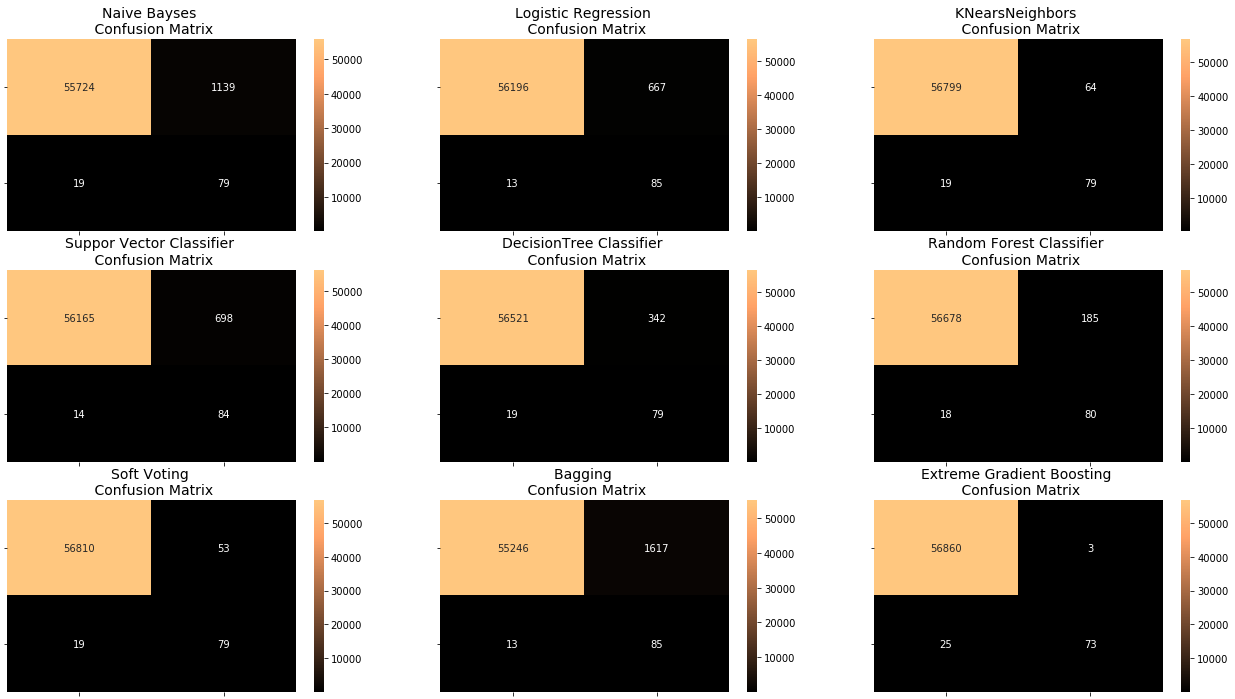

In [59]:
plot_confusion_matrix(original_ytest, nbc_pred, log_reg_pred, knn_pred, svc_pred, dtc_pred, rfc_pred, votc2_pred, bagc_pred, xgbc_pred)